## Config Variables and Load CSV Data

In [1]:
import csv

image_data_path = 'Data/data'

csv_data = []
with open(image_data_path + '/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        csv_data.append(row)

## Load Images

### Function to read an pre-process image

In [2]:
import numpy as np
import cv2
import sklearn

''' Function to pasrse source path and load image '''

def image_loader(path):
    filename = path.split('/')[-1]
    current_path = image_data_path + '/IMG/' + filename
    image = cv2.imread(current_path)

    return image


''' Function to loop through CSV and load a list of images and measurements '''

def csv_loader(csv_data, image_index=0, correction = 0.0, measurement_index=3):    
    images = []
    measurements = []

    for row in csv_data:
        source_path = row[image_index]
        measurement = float(row[measurement_index]) + correction

        images.append(image_loader(source_path))        
        measurements.append(measurement)
            
    assert len(images) == len(measurements)
    return images, measurements
    

''' Function that read and return a list of flipped images and measurements '''

def flip_images(image_list, measurement_list):
    n_images = len(image_list)
    n_measurements = len(measurement_list)
    assert n_images == n_measurements
    
    flipped_images = []
    flipped_measurements = []
    for i in range(n_images):
        flipped_images.append(np.fliplr(image_list[i]))
        flipped_measurements.append(-measurement_list[i])
        
    return flipped_images, flipped_measurements


''' Generator to load images '''

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: 
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

### Load the Images from the front camera

In [4]:
images, measurements = csv_loader(csv_data)

n_center_images = len(images)

### The 2 cells bellow can load the images for the left and right camera

Left Camera

In [5]:
images_left, measurements_left = csv_loader(csv_data, image_index=1, correction= 0.2)

images.extend(images_left)
measurements.extend(measurements_left)

Right Camera

In [6]:
images_right, measurements_right = csv_loader(csv_data, image_index=2, correction= -0.2)

images.extend(images_right)
measurements.extend(measurements_right)

#### Images shape

In [7]:
image_shape = images[0].shape
n_images = len(images)
print('Number of images:', n_images)
print('Image shape:',image_shape)

Number of images: 79665
Image shape: (160, 320, 3)


Image sample (Center/Left/Right)

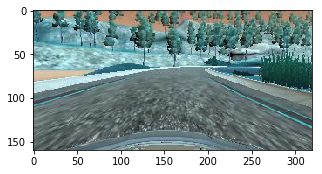

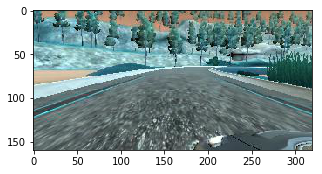

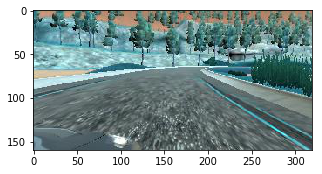

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

center_index = 220

# Display Center Image
img = images[center_index].squeeze()
plt.figure(figsize=(5,5))
plt.imshow(img)

# Display Left Image
if('images_left' in vars()):
    img = images[center_index+n_center_images].squeeze()
    plt.figure(figsize=(5,5))
    plt.imshow(img)

# Display Right Image
if('images_right' in vars()):
    img = images[center_index+2*n_center_images].squeeze()
    plt.figure(figsize=(5,5))
    plt.imshow(img)

### Run this cell to enhance the set with flipped images

In [9]:
flipped_images, flipped_measurements = flip_images(images, measurements)

images.extend(flipped_images)
measurements.extend(flipped_measurements)

In [10]:
print('Number of images:', len(images))

Number of images: 159330


Sample (Normal/Flipped)

In [ ]:
normal_index = 300

# Display normal Image
img = images[normal_index].squeeze()
plt.figure(figsize=(5,5))
plt.imshow(img)

# Display flipped image
img = images[normal_index + n_images].squeeze()
plt.figure(figsize=(5,5))
plt.imshow(img)

#### Load X and y train

In [11]:
X_train = np.array(images)
y_train = np.array(measurements)

## Linear Network Model

In [ ]:
from keras.layers import Flatten, Dense, Lambda
from keras.models import Sequential

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=image_shape))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=2)

model.save('model.h5py')
print('DONE!')

## LeNet Network Model

In [ ]:
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D
from keras.models import Sequential
from keras.models import Model

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=image_shape))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(6, 5, 5, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=7)

model.save('lenet_model.h5py')
print('DONE!')

## NVIDIA Network Model

In [ ]:
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D
from keras.models import Sequential
from keras.models import Model

model = Sequential()
# model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=image_shape))
# model.add(Lambda(lambda x: (x / 255.0) - 0.5))

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=image_shape))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=10)

model.save('nvidia_center.h5py')
print('DONE!')

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  app.launch_new_ins

Train on 127464 samples, validate on 31866 samples
Epoch 1/10
   448/127464 [..............................] - ETA: 6846s - loss: 0.0260

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.174729). Check your callbacks.
  % delta_t_median)


127464/127464 [==============================] - 91s - loss: 0.0111 - val_loss: 0.0265
Epoch 2/10
127464/127464 [==============================] - 66s - loss: 0.0084 - val_loss: 0.0318
Epoch 3/10
127464/127464 [==============================] - 67s - loss: 0.0070 - val_loss: 0.0246
Epoch 4/10
127464/127464 [==============================] - 66s - loss: 0.0063 - val_loss: 0.0312
Epoch 5/10
127464/127464 [==============================] - 66s - loss: 0.0058 - val_loss: 0.0263
Epoch 6/10
127464/127464 [==============================] - 65s - loss: 0.0054 - val_loss: 0.0288
Epoch 7/10
127464/127464 [==============================] - 67s - loss: 0.0051 - val_loss: 0.0242
Epoch 8/10
127464/127464 [==============================] - 66s - loss: 0.0048 - val_loss: 0.0241
Epoch 9/10
 11776/127464 [=>............................] - ETA: 50s - loss: 0.0043